# Surviving the Titanic

Using data about the passengers aboard the Titanic, I will use machine learning to predict if a passenger survived or not. To accomplish this I will first clean the data, feature engineer new variables, then train a model and use it to predict survival.


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score

# Data Cleaning


In [2]:
#import the train and test sets from kaggle
train = pd.read_csv("C:/Users/zachp/Downloads/train_titanic.csv")
test = pd.read_csv("C:/Users/zachp/Downloads/test_titanic.csv")


In [3]:
#make the PassengerId variable the index variable
train.set_index('PassengerId', inplace = True)
test.set_index('PassengerId', inplace = True)
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


After looking at the data, I know that age has missing values so before I can run any preliminary models I need to fill in the values for age. I will fill the missing values with the average age of the training data on both the train and test data sets. 

In [4]:
train['Age'] = train['Age'].fillna(train.Age.mean())
test['Age'] = test['Age'].fillna(train.Age.mean())
#check to make sure there are 891 observations of age in the training data
train['Age'].count()



891

In [5]:
#now split into training and test set
target = train['Survived']
train = train.drop('Survived', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=42)


Now the data is cleaned and split into a train and test data set I can build a basic model. Even though this is early in the process I want train and test a model so I can see how much additional cleaning I will need to do. I can also see the effect of cleaning, scaling, and feature engineering by comparing new models to this original model. For this model, I will ignore all object variables and just use the orignial numeric variables. 

In [6]:
numeric_variables = list(X_train.dtypes[X_train.dtypes!= 'object'].index)
X_train[numeric_variables].describe()

,Pclass,Age,SibSp,Parch,Fare
count,596.000000,596.000000,596.000000,596.000000,596.000000
mean,2.337248,29.560262,0.577181,0.374161,31.912786
std,0.823207,12.944885,1.229504,0.807072,51.480961
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.925000
50%,3.000000,29.699118,0.000000,0.000000,14.454200
75%,3.000000,35.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,6.000000,512.329200


#  Random Forest

Random forests train a bunch of decision trees that are all different and then combine them via voting. Basically, you take the most common predicted class as the prediction (hard voting) and you can get probabilities by taking the fraction (soft voting). It is fairly easy to see how multiple models might be more effective than a single model if they all look at the data in a different way. Random Forest assumes taht group thinking is the same as an expert opinion. 

In [7]:
#now I will use a for loop to determine what the best parameters are. 


n_estimators = [5000]
max_depth = [5]
class_weights = ['balanced', None]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        for wgt in class_weights:
            print(est, depth, wgt)
            clf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight=wgt)
            clf.fit(X_train[numeric_variables],y_train)
            f1 = f1_score(y_train, np.argmax(clf.oob_decision_function_ , 1))
            if f1 > best_f1:
                best_f1 = f1
                best_params = (est, depth, wgt)

5000 5 balanced
5000 5 None


In [8]:
print("Best OOB F1: {}".format(best_f1))
print("Best params: {}".format(best_params))

Best OOB F1: 0.5838509316770186
Best params: (5000, 5, 'balanced')


In [9]:
model1 = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1], class_weight=best_params[2])

model1.fit(X_train[numeric_variables],y_train)

test_predictions = model1.predict(X_test[numeric_variables])
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))

Test Classification Report:
             precision    recall  f1-score   support

          0       0.80      0.72      0.76       175
          1       0.64      0.73      0.68       120

avg / total       0.73      0.73      0.73       295



This first model is ok but not great. I will try some additional cleaning and feature engineering and then make a new model. 

In [10]:
def describe_categorical(X):
    from IPython.display import display, HTML
    display(HTML(X_train[X_train.columns[X_train.dtypes == 'object']].describe().to_html()))
describe_categorical(X_train)

,Name,Sex,Ticket,Cabin,Embarked
count,596,596,596,134,595
unique,596,2,480,104,3
top,"Coleridge, Mr. Reginald Charles",male,CA. 2343,C23 C25 C27,S
freq,1,390,7,4,437


The variables of passenger Id, Name, and Ticket all identify the passengers. For now we can drop Name and Ticket because we are using passenger ID as the index variable. Then from the table I know that Sex, Cabin, and Embarked can all be made into dummy variables. I will clean cabin so that just the cabin category (eg: Cabin A) will have a dummy variable. Then I will make dummies for sex and embarked port. 

In [11]:
train = train.drop('Name', axis = 1)
train = train.drop('Ticket', axis = 1)


In [12]:
test = test.drop('Name', axis = 1)
test = test.drop('Ticket', axis = 1)

In [13]:
def clean_cabin(x):
    try: 
        return x[0]
    except TypeError:
        return "None"
train['Cabin'] = train.Cabin.apply(clean_cabin)

test['Cabin'] = test.Cabin.apply(clean_cabin)

In [14]:
categorical_variables = ['Sex', 'Cabin', 'Embarked']

for variable in categorical_variables:
    train[variable].fillna('Missing', inplace = True )
    dummies = pd.get_dummies(train[variable], prefix = variable)
    train = pd.concat([train, dummies], axis =1)
    train.drop([variable], axis = 1, inplace = True)
test_categorical_variables =test[['Sex', 'Cabin', 'Embarked']]
    
for variable in test_categorical_variables:
    test[variable].fillna('Missing', inplace = True )
    dummies = pd.get_dummies(test[variable], prefix = variable)
    test = pd.concat([test, dummies], axis =1)
    test.drop([variable], axis = 1, inplace = True)
    

In [15]:
#look at the data to make sure the dummies where created right
train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,,,,,
1,3,22.0,1,0,7.2500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,1,38.0,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,3,26.0,0,0,7.9250,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
5,3,35.0,0,0,8.0500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1


In [16]:
#now I can resplit my data to make a second hopefully more accurate random forest classifer. 

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=42)

rf_model2 = RandomForestClassifier(n_estimators = 100, oob_score = True, n_jobs = -1, random_state= 42)
rf_model2.fit(X_train, y_train)
test_predictions = rf_model2.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))

Test Classification Report:
             precision    recall  f1-score   support

          0       0.80      0.85      0.83       175
          1       0.76      0.69      0.72       120

avg / total       0.78      0.79      0.78       295



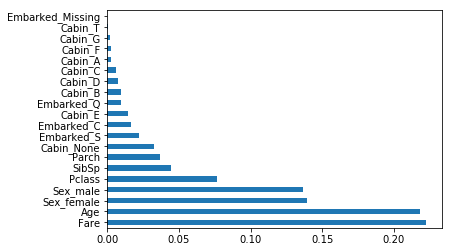

In [17]:
#Now I want to look that most important features
feature_imp = sorted(list(zip(train.columns, rf_model2.feature_importances_)), key=lambda x: x[1], reverse=True)
pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp]).plot(kind='barh')


I can tell from the graph that Fare, Age, Sex, and Pclass are the most important variables so I will do additional feature engineer to those variables

In [18]:
train[['Fare', 'Age', 'Sex_male', 'Sex_female', 'Pclass']].describe()

,Fare,Age,Sex_male,Sex_female,Pclass
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,32.204208,29.699118,0.647587,0.352413,2.308642
std,49.693429,13.002015,0.477990,0.477990,0.836071
min,0.000000,0.420000,0.000000,0.000000,1.000000
25%,7.910400,22.000000,0.000000,0.000000,2.000000
50%,14.454200,29.699118,1.000000,0.000000,3.000000
75%,31.000000,35.000000,1.000000,1.000000,3.000000
max,512.329200,80.000000,1.000000,1.000000,3.000000


In [19]:
#spliting the age variable into 5 baskets
train['age_bin'] = pd.cut(train['Age'].astype(int), 5)
test['age_bin'] = pd.cut(test['Age'].astype(int), 5)

#splitting the fare variable into 5 baskets
train['fare_bin'] = pd.cut(train['Fare'], 4)
test['fare_bin'] = pd.cut(test['Fare'], 4)



In [20]:
#dropping the original variables

train = train.drop('Age', axis = 1)
test = test.drop('Age', axis =1 )
train = train.drop('Fare', axis = 1)
test = test.drop('Fare', axis = 1)

In [21]:
#making a family size variable which is found by adding the sibling and parent column together
train['family_size'] = train['SibSp'] + train['Parch'] + 1
test['family_size'] = test['SibSp'] + test['Parch'] + 1

#making a dummy variable for if the travelor had no family with them
train['is_alone'] = train['family_size'].apply(lambda x: 1 if x == 1 else 0)
test['is_alone'] = test['family_size'].apply(lambda x: 1 if x == 1 else 0)

#making a dummy variable for each passenger class
pclass = pd.get_dummies(train['Pclass']) 
pclass2 = pd.get_dummies(test['Pclass'])
train = pd.concat([train, pclass], axis = 1)
test = pd.concat([test, pclass2], axis = 1)

In [22]:
age_bin = pd.get_dummies(train[['age_bin', 'fare_bin']])
train = pd.concat([train, age_bin], axis = 1)
train = train.drop(['age_bin'], axis = 1)
train = train.drop(['fare_bin'], axis = 1)

In [ ]:
age_bin2 = pd.get_dummies(test[['age_bin', 'fare_bin']])
test = pd.concat([test, age_bin2], axis = 1)
test = test.drop(['age_bin'], axis = 1)
test = test.drop(['fare_bin'], axis = 1)

Now that I've done more feature engineering, I can try a 3rd model with random forest. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=42) 

n_estimators = [1000, 2500, 5000]
max_depth = [1, 3, 5, 10]
class_weights = ['balanced', None]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        for wgt in class_weights:
            print(est, depth, wgt)
            clf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight=wgt)
            clf.fit(X_train,y_train)
            f1 = f1_score(y_train, np.argmax(clf.oob_decision_function_ , 1))
            if f1 > best_f1:
                best_f1 = f1
                best_params = (est, depth, wgt)

1000 1 balanced
1000 1 None
1000 3 balanced
1000 3 None
1000 5 balanced
1000 5 None
1000 10 balanced
1000 10 None
2500 1 balanced
2500 1 None
2500 3 balanced
2500 3 None
2500 5 balanced
2500 5 None
2500 10 balanced
2500 10 None
5000 1 balanced
5000 1 None


In [ ]:


rf_model3 = (n_estimators=best_params[0], max_depth=best_params[1], class_weight=best_params[2])
rf_model3.fit(X_train, y_train)
test_predictions = rf_model3.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))

#  K Nearest Neighbors Classification 


Now that I have a good predition using Random Forest I will use the K-Nearest Neighbors Classifier 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
gridsearch = GridSearchCV(clf, {"n_neighbors": [1, 3, 5, 7,8, 9, 10, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1')
gridsearch.fit(X_train, y_train)

#evaluate model

print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)))

The K Nearest Neighbors Classifier does predict as well as the random forest classifier. The f1 score of k nearest neighbors is lower than the f1 score of rf_model3

# SVM 


In [ ]:
from sklearn.model_selection import  GridSearchCV
from sklearn.svm import SVC

clf = SVC()
svm = GridSearchCV(clf, {"C": [0.2, 0.5, 0.7], "kernel": ['linear', 'poly', 'rbf'], 

                                'degree': [1, 2, 3], 'gamma': [1, 5, 11]}, scoring='accuracy')
svm.fit(X_train, y_train)
#evaluate model

print("Best Params: {}".format(gridsearch.best_params_))
print("Test Accuracy: {}".format(accuracy_score(y_test, gridsearch.predict(X_test))))
print(classification_report(y_test, y_pred_test))

After comparing Random Forest, K Nearest Neighbors, and SVM classifiers, I decided that random forest gave the best predictions. This is because the f1 - score was highest for random forest. While the random forest prediction isn't perfect it gives an accurate prediction. 

# Submitting to Kaggle

In [ ]:
test = test.fillna(train.mean())

In [ ]:
test['Embarked_Missing'] = 0
test['Cabin_T'] = 0

In [ ]:
pred = rf_model3.predict(test)

submission = pd.DataFrame({'PassengerId':test.index,'Survived':pred})
submission.to_csv('submission.csv', index=False)